sigma^2 = lambda * sigma(prev)^2 + (1-lambda)return^2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import data_reader as dr

In [2]:
data, source = dr.read('kospi_extended.csv')
data.info()

Loading data from file /home/changhyun/workspace/cxk858/dataset/kospi_extended.csv...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2461
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2456 non-null   object 
 1   Open                 2456 non-null   float64
 2   High                 2456 non-null   float64
 3   Low                  2456 non-null   float64
 4   Close                2456 non-null   float64
 5   Adj Close            2456 non-null   float64
 6   Volume               2456 non-null   float64
 7   Daily_trading_range  2456 non-null   float64
 8   Log_Volume_change    2455 non-null   float64
 9   Daily_return         2455 non-null   float64
 10  Daily_log_return     2455 non-null   float64
 11  Target               2434 non-null   float64
dtypes: float64(11), object(1)
memory usage: 249.4+ KB


In [3]:
data = data.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily_return'], axis=1)
data['Squared_return'] = data['Daily_log_return']**2
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2461
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2456 non-null   float64
 1   Log_Volume_change    2455 non-null   float64
 2   Daily_log_return     2455 non-null   float64
 3   Target               2434 non-null   float64
 4   Squared_return       2455 non-null   float64
dtypes: float64(5)
memory usage: 115.1 KB


In [4]:
sqreturn = data[['Squared_return']].iloc[22:,0]
target = np.array(data[['Target']].dropna())
target = pd.DataFrame(target)
vol_init = np.sqrt(data[['Squared_return']].iloc[0:22,0].mean()*252)
for i in range(1,22):
    vol_init = vol_init + data[['Squared_return']].iloc[i]*0.06**i
sqreturn

22      2.185806e-05
23      3.364501e-05
24      1.374123e-04
25      3.346401e-04
26      2.468531e-04
            ...     
2457    9.056992e-05
2458    2.856429e-04
2459    3.840461e-07
2460    1.790601e-05
2461    3.460577e-04
Name: Squared_return, Length: 2434, dtype: float64

In [5]:
pred_vol = []
pred_vol.append(vol_init)
testSize = int(len(sqreturn)*0.2)
trainResid = sqreturn

vol_init

Squared_return    0.116992
dtype: float64

In [44]:
sqreturn

22      2.185806e-05
23      3.364501e-05
24      1.374123e-04
25      3.346401e-04
26      2.468531e-04
            ...     
2457    9.056992e-05
2458    2.856429e-04
2459    3.840461e-07
2460    1.790601e-05
2461    3.460577e-04
Name: Squared_return, Length: 2434, dtype: float64

In [6]:
# Training session
lamb = 0.94
window = 21
for i in range(len(sqreturn)-testSize):
    rv = data[['Squared_return']].iloc[i:i+window,0].mean()*252
    pred = lamb * rv + (1-lamb) * sqreturn.iloc[0]
    pred_vol.append(np.sqrt(pred))

len(pred_vol)

1949

In [7]:
res = 0.94 * vol_init + (0.06)*sqreturn.iloc[0]
res

Squared_return    0.109974
dtype: float64

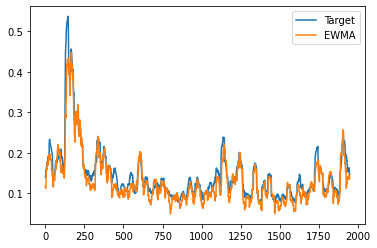

In [8]:
plt.plot(target.iloc[:len(sqreturn)-testSize], label='Target')
plt.plot(pred_vol[1:], label='EWMA')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [12]:
testScore = mean_squared_error(target.iloc[:len(sqreturn)-testSize], pred_vol[1:])
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(target.iloc[:len(sqreturn)-testSize], pred_vol[1:], squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(target.iloc[:len(sqreturn)-testSize], pred_vol[1:])
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.0005875799966730248 MSE
test Score: 0.024240049436274357 RMSE
test Score: 0.11813410394945227 MAPE


In [41]:
# test
prev_vol = pred_vol[-1]
test_pred = []
test_pred.append(prev_vol)
for i in range(len(sqreturn)-testSize,len(sqreturn)):
    ewm = 0

    # for j in range(i,i+window):
    #     ewm = ewm + data[['Squared_return']].iloc[j] * ((1-lamb) ** (j-i+1))

    rv = data[['Squared_return']].iloc[i:i+window,0].mean()*252
    test_vol = lamb*rv + (1-lamb)*sqreturn.iloc[i]
    test_pred.append(np.sqrt(test_vol))

test_pred = test_pred[1:]
test_target = np.array(target.iloc[len(sqreturn)-testSize:])
test_target = pd.DataFrame(test_target)

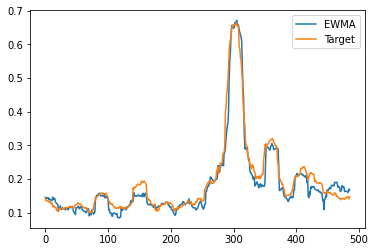

In [48]:
plt.plot(test_pred, label='EWMA')
plt.plot(test_target, label='Target')
plt.legend()
plt.savefig('images/EWMA.png')
plt.show()

In [43]:
testScore = mean_squared_error(test_target, test_pred)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(test_target, test_pred, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(test_target, test_pred)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.000674805664439937 MSE
test Score: 0.025977021854707228 RMSE
test Score: 0.09741024091936207 MAPE
